In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [7]:
data = pd.read_excel('sample_data.xlsx')
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y%m%d') # Convert data to pandas date format

print(data.shape)
print(data.head())

(13236, 23)
        DATE           INDUSTRY     RET1M   FACTOR_A   FACTOR_B  FACTOR_C   
0 2009-12-31  Consumer Services -6.772226 -10.997537   1.243996  3.206262  \
1 2009-12-31        Health Care -1.203936 -11.335562   6.677766  6.647280   
2 2009-12-31          Utilities -5.108941  -9.092325   7.201676 -1.721651   
3 2009-12-31  Consumer Services -9.497839  -8.027924   1.511073  6.260253   
4 2009-12-31        Industrials       NaN  -7.154560 -22.110048  9.091127   

    FACTOR_D   FACTOR_E  FACTOR_F    FACTOR_G  ...   FACTOR_K   FACTOR_L   
0   2.490379   6.002323  0.000000  165.035110  ...  20.725244  48.789809  \
1   9.272592  25.475441  2.963510    5.021560  ...  26.212564  16.894423   
2  13.804003  51.570755  0.000000   54.611650  ...  13.964652  -0.572733   
3  13.414311  56.804149  2.008608   76.116165  ...   2.660146  10.793099   
4   5.220209  48.536897  0.000000   81.274890  ... -45.553073  18.730342   

   FACTOR_M  FACTOR_N    FACTOR_O    FACTOR_P   FACTOR_Q  FACTOR_R  

In [8]:
print(data.describe())

                                DATE         RET1M      FACTOR_A   
count                          13236  13200.000000  13236.000000  \
mean   2016-03-15 21:26:29.483227392      1.183739     -9.458429   
min              2009-12-31 00:00:00    -83.226326    -14.880788   
25%              2012-12-31 00:00:00     -3.598824    -10.275918   
50%              2016-02-29 00:00:00      1.147062     -9.313366   
75%              2019-05-31 00:00:00      5.719176     -8.411034   
max              2022-07-29 00:00:00    213.516739     -5.846497   
std                              NaN      9.276264      1.380750   

           FACTOR_B      FACTOR_C      FACTOR_D      FACTOR_E      FACTOR_F   
count  13235.000000  13235.000000  13233.000000  13236.000000  12863.000000  \
mean       2.747661      3.841751     10.407276     39.827840      1.993655   
min     -695.521061   -177.201346    -46.741703   -102.804489      0.000000   
25%        2.412640      1.741002      6.659139     17.619053      0.17

In [9]:
print("Start Date: ", data['DATE'].min())
print("End Date: ", data['DATE'].max())
print("--------")
print("Different Industries: ")
print(data['INDUSTRY'].unique())
print("--------")
print(" Mean returns for different industries: ")
mean_ret1m_by_industry = data.groupby('INDUSTRY')['RET1M'].mean()
print(mean_ret1m_by_industry)

Start Date:  2009-12-31 00:00:00
End Date:  2022-07-29 00:00:00
--------
Different Industries: 
['Consumer Services' 'Health Care' 'Utilities' 'Industrials' 'Technology'
 'Basic Materials' 'Oil & Gas' 'Consumer Goods' 'Telecommunications']
--------
 Mean returns for different industries: 
INDUSTRY
Basic Materials       1.156965
Consumer Goods        1.061675
Consumer Services     1.424321
Health Care           1.187328
Industrials           1.235673
Oil & Gas             1.198911
Technology            1.621760
Telecommunications    0.558382
Utilities             1.025734
Name: RET1M, dtype: float64


In [10]:
### Data Preprocessing ###

# Sort the data by date
data.sort_values(by='DATE', inplace=True)


# Remove all the data points for which the value for ‘RET1M’ is missing. 
# This is because it is the target variable and imputing values for it would make the process biased. 
data.dropna(subset=['RET1M'], inplace=True)

# Check the features that are missing values. 
num_missing_features = data.isnull().sum(axis=1)
data_points_with_missing_features = data[num_missing_features > 2]
print("Number of data points with more than 2 missing features: ", len(data_points_with_missing_features)) # Prints 66

# The data has only a small number of data points (compared to the size of the dataset) that are missing values for more than 2 features. 
# This means that I can safely impute missing values without affecting the data significantly. 
# I am replacing missing values by the mean of the value from the industry the data point belongs to
data.fillna(data.groupby('INDUSTRY').transform('mean'), inplace=True)

# One hot encoding to encode the industry column as a numerical feature so that it could be used by the model more effectively.
encoded_data = pd.get_dummies(data['INDUSTRY'], prefix='INDUSTRY')
data = pd.concat([data, encoded_data], axis=1)

# I will scale the data later, before the model training, to prevent the information from test sets from being used for the model training. 

Number of data points with more than 2 missing features:  66


In [11]:
# Get the correlation between the target variable and the features
correlation = data.iloc[:, 2:].corr()['RET1M']
print(correlation)
# The values are very low, signalling that there might be little to no linear correlation. 
# So I will be using non-linear regression models to better capture the relationship between the variables

RET1M                          1.000000
FACTOR_A                       0.008091
FACTOR_B                      -0.076110
FACTOR_C                       0.012823
FACTOR_D                       0.001687
FACTOR_E                       0.016869
FACTOR_F                       0.001483
FACTOR_G                       0.000678
FACTOR_H                       0.020506
FACTOR_I                       0.003888
FACTOR_J                      -0.010396
FACTOR_K                       0.012870
FACTOR_L                       0.012319
FACTOR_M                      -0.076249
FACTOR_N                      -0.017189
FACTOR_O                       0.016474
FACTOR_P                       0.010322
FACTOR_Q                       0.012996
FACTOR_R                       0.037411
FACTOR_S                       0.021084
FACTOR_T                       0.031706
INDUSTRY_Basic Materials      -0.001040
INDUSTRY_Consumer Goods       -0.004744
INDUSTRY_Consumer Services     0.009339
INDUSTRY_Health Care           0.000139


In [12]:
# Group the data by date. 
# Since data is recorded on only one date each month, all groups contains the data for the corresponding month
# I am considering each month(group) to be 1 period. 
grouped_data = data.groupby('DATE')
data_groups_df = [x[1] for x in list(grouped_data)] # A list of dataframes, each containing the data for a month


In [13]:
### Fitting the model and making predictions on a rolling basis ###

start_window_size = 32 
step_size = 4 

# This array will contain the mse values for the predictions on the test set for each model
test_mse_values = []

# Separate the data into features and target variable
data_features = list(map(lambda x: x.iloc[:, 3:], data_groups_df))
target_variables = list(map(lambda x: x['RET1M'], data_groups_df))

# Store predictions and actual values for the last test set to plot them later
predictions = []
actual_values = []

# The data intervals are anchored on the left end and the step size is 4. 

for window_end in range(start_window_size - 1, len(data_features), step_size):
    
    # Get the training and test data. The test data is the next 4 months after the training data and is the out-of-sample data since it is not used in the training process
    X_train, y_train = pd.concat(data_features[: window_end - 3]), pd.concat(target_variables[: window_end - 3])
    X_test, y_test = pd.concat(data_features[window_end - 3: window_end + 1]), pd.concat(target_variables[window_end - 3: window_end + 1])

    # Create a pipeline for scaling the data and then fitting the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf')) # Using the radial basis function kernel for the SVR model to capture non-linear relationships
    ])

    # Since the dataset is quite large, I will be using Halving Random Search to perform hyperparameter tuning.
    param_grid = {
        'regressor__C': list(np.linspace(0.1, 10, 10)),
        'regressor__gamma': list(np.linspace(0.01, 1, 10)),
        'regressor__epsilon': list(np.linspace(0.01, 1, 10))
    }
    halving_search = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    # Fit the model and perform hyperparameter tuning
    halving_search.fit(X_train, y_train)

    # Get the best estimator from the hyperparameter tuning
    best_estimator = halving_search.best_estimator_

    training_mse = mean_squared_error(y_train, best_estimator.predict(X_train))
    print("Training MSE: ", training_mse)
    test_mse = mean_squared_error(y_test, best_estimator.predict(X_test))
    test_mse_values.append(test_mse)
    print("Test MSE: ", test_mse)

    # For the last window, store the predictions and actual values so that they can be plotted
    if window_end == len(data_features) - 1:
        predictions = best_estimator.predict(X_test)
        actual_values = y_test

Training MSE:  38.22630021337708
Test MSE:  81.42211310981348
Training MSE:  71.66810886856304
Test MSE:  44.830879957556476
Training MSE:  59.14003480984422
Test MSE:  51.8476067173801
Training MSE:  51.32893108700573
Test MSE:  64.21166539032515
Training MSE:  64.11130188361008
Test MSE:  34.29351979162735
Training MSE:  70.54793401946759
Test MSE:  50.279117185158945
Training MSE:  68.94087331730243
Test MSE:  33.755343794412234
Training MSE:  57.26194109804373
Test MSE:  53.39227392497224
Training MSE:  33.473476151632845
Test MSE:  63.94287951195139
Training MSE:  65.03779703424941
Test MSE:  69.99607123277143
Training MSE:  39.3719905976487
Test MSE:  99.67255894614003
Training MSE:  67.00542639036573
Test MSE:  117.0426358094846
Training MSE:  69.52741590979981
Test MSE:  60.69023342885591
Training MSE:  41.83253393163723
Test MSE:  58.350064878621325
Training MSE:  46.40222256647895
Test MSE:  50.17135721410246
Training MSE:  51.42098544122486
Test MSE:  62.05307611791391
Train

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1013. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  33.60355367118205
Test MSE:  78.67414561598896


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1047. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  61.92819031920377
Test MSE:  502.08412811075954


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1081. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  68.15133486140739
Test MSE:  85.09967141519448


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1115. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  49.89889198390066
Test MSE:  134.94147400286946


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1149. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  66.98877053100438
Test MSE:  82.42955271959849


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1183. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  50.66716881504938
Test MSE:  52.11309521087749


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1217. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  83.6631194820889
Test MSE:  75.48594160966621


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1252. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  49.771776000256125
Test MSE:  104.51228754747365


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1000 is smaller than n_iter=1286. Running 1000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training MSE:  58.92873797800535
Test MSE:  131.51086699321777


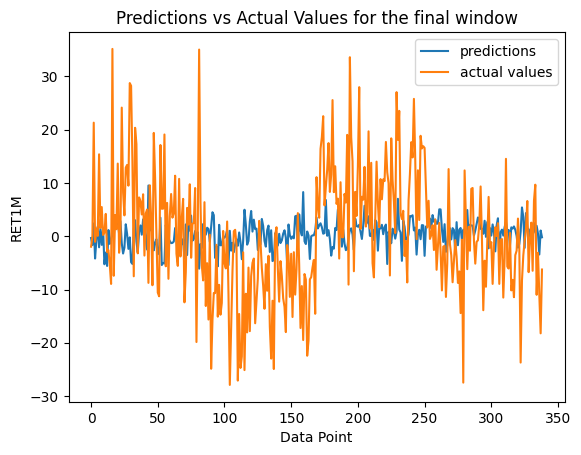

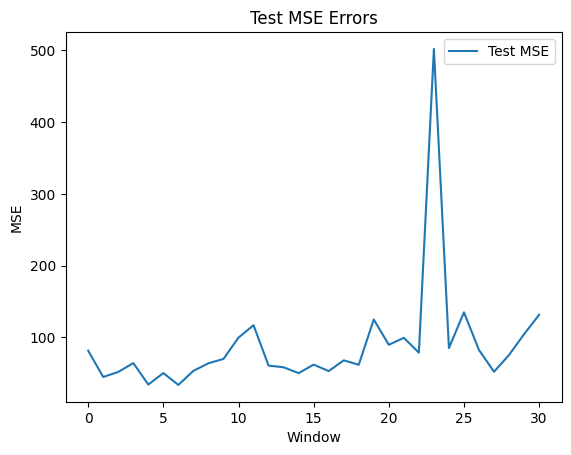

In [14]:
# Plot the predictions and the actual values for the final window
plt.plot(list(predictions), label='predictions')
plt.plot(list(actual_values), label='actual values')
plt.xlabel('Data Point')
plt.ylabel('RET1M')
plt.title('Predictions vs Actual Values for the final window')
plt.legend()
plt.show()

# Plot the training and test MSE errors
plt.plot(test_mse_values, label='Test MSE')
plt.xlabel('Window')
plt.ylabel('MSE')
plt.title('Test MSE Errors')
plt.legend()
plt.show()


# The model does not produce any meaningful results. The predicted values are way too low, and the mean squared error is really high. 
# This might have been caused by the size of the dataset, or the kernel not being able to capture the non-linearity of the data. 
# I also tried other regression models but none of them produced any good results. 
# The inherent complexity of the data makes the return values hard to predict.